### Data Source: https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/data

## Import Packages

In [44]:
# Baseic Modules
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Modules for Machine Learning
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

## Read in data

In [45]:
ranking = pd.read_excel('/Users/alex/Desktop/SideProject/Soccer Prediction/fifa_ranking.xls')
results = pd.read_csv('/Users/alex/Desktop/SideProject/Soccer Prediction/results.csv')
world_cup = pd.read_excel('/Users/alex/Desktop/SideProject/Soccer Prediction/World Cup 2018 Dataset.xlsx', sheet_name='32round')

In [46]:
ranking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [47]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [48]:
world_cup.head()

,Group,Team1,Team2
0,A,Russia,Saudi Arabia
1,A,Russia,Egypt
2,A,Russia,Uruguay
3,A,Saudi Arabia,Egypt
4,A,Saudi Arabia,Uruguay


## Data Preprocessing

#### First, I would like to use the data 'results' joint 'ranking' as our training data.

In [49]:
# Originally rank_date is a timestamp, so I'll fisrt transform it into string and only select year and month
ranking['new_date'] = ranking.rank_date.astype(str).str[:7]

# Do the same thing on the other dataframe
# In dataframe 'results', we will only use the data that starts from the date 1993-08 to fit another dataframe 'ranking'
results['new_date'] = results.date.astype(str).str[:7]
results = results.iloc[17786:, ]
# Joint the two dataframes by the column 'new_date', 'hometeam' or 'away_team'
# We will first joint the home_team data in
dataset = pd.merge(results, ranking, how='inner', left_on=['new_date', 'home_team'], right_on=['new_date', 'country_full'])
# We then pick out the parameters that we're interested in 
dataset = dataset.loc[:, ['new_date','home_team', 'rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
                          'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 
                          'three_year_ago_avg', 'three_year_ago_weighted', 'away_team', 'home_score', 'away_score', 'tournament']]
# Next, we will merge it again for the away_team data
dataset = pd.merge(dataset, ranking, how='inner', left_on=['new_date', 'away_team'], right_on=['new_date', 'country_full'])
# final_dataset
final_dataset = dataset.drop(columns=['country_full', 'country_abrv', 'confederation', 'rank_date'])

#### Next, we will add a new column that shows if the home team wins or lose or it's a tie.

In [60]:
# move 'tournament', home_score' and 'away_score' to the last columns
cols = list(final_dataset.columns.values) 
cols.pop(cols.index('tournament'))
cols.pop(cols.index('home_score')) 
cols.pop(cols.index('away_score')) 
final_dataset = final_dataset[cols+['tournament', 'home_score','away_score']] 

conditions = [final_dataset['home_score'] > final_dataset['away_score'], 
             final_dataset['home_score'] == final_dataset['away_score'], 
             final_dataset['home_score'] < final_dataset['away_score']]
choices = ['win', 'tie', 'lose']  # 1 means home_team wins; -1 means home_team loses: 0 means it's a tie

final_dataset['outcome'] = np.select(conditions, choices)

#### After preprocessing, I'll show how our final_dataset looks like.

In [62]:
final_dataset.iloc[0:10, :14]

,new_date,home_team,rank_x,total_points_x,previous_points_x,rank_change_x,cur_year_avg_x,cur_year_avg_weighted_x,last_year_avg_x,last_year_avg_weighted_x,two_year_ago_avg_x,two_year_ago_weighted_x,three_year_ago_avg_x,three_year_ago_weighted_x
0,1993-08,Colombia,19,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1993-08,Argentina,5,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1993-08,Colombia,19,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1993-08,Peru,70,0.0,16,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1993-08,Paraguay,67,0.0,22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1993-08,Colombia,19,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1993-08,Paraguay,67,0.0,22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1993-08,Argentina,5,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1993-08,Peru,70,0.0,16,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1993-08,Paraguay,67,0.0,22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
final_dataset.iloc[0:10, 14:]

,away_team,rank_y,total_points_y,previous_points_y,rank_change_y,cur_year_avg_y,cur_year_avg_weighted_y,last_year_avg_y,last_year_avg_weighted_y,two_year_ago_avg_y,two_year_ago_weighted_y,three_year_ago_avg_y,three_year_ago_weighted_y,tournament,home_score,away_score,outcome
0,Paraguay,67,0.0,22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,0,0,tie
1,Paraguay,67,0.0,22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,0,0,tie
2,Argentina,5,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,2,1,win
3,Argentina,5,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,0,1,lose
4,Argentina,5,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,1,3,lose
5,Peru,70,0.0,16,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,4,0,win
6,Peru,70,0.0,16,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,2,1,win
7,Peru,70,0.0,16,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,2,1,win
8,Colombia,19,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,0,1,lose
9,Colombia,19,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FIFA World Cup qualification,1,1,tie


In [35]:
# I decided to export it out to excel so maybe I can use tableau to draw some graphs which may help me on choosing the variables.
# writer = ExcelWriter('final_dataset.xlsx')
# final_dataset.to_excel(writer, 'sheet1')
# writer.save()

## Choose different ways of selecting variables for training data

### Method 1
#### We'll  do a subtraction on the stats of home_team and away_team as our variable

In [64]:
# Create a new dataframe so it's convienient for me to test different methods from the 'final_dataset'
# We will use a subtraction between home_team stats and away_team stats as our new variables

method1 = pd.DataFrame()
method1['new_date'] = final_dataset['new_date']
method1['home_team'] = final_dataset['home_team']
method1['away_team'] = final_dataset['away_team']
method1['rank_sub'] = final_dataset['rank_x'] - final_dataset['rank_y']
method1['total_points_sub'] = final_dataset['total_points_x'] - final_dataset['total_points_y']
method1['previous_points_sub'] = final_dataset['previous_points_x'] - final_dataset['previous_points_y']
method1['rank_changesub'] = final_dataset['rank_change_x'] - final_dataset['rank_change_y']
method1['cur_year_sub'] = final_dataset['cur_year_avg_x'] - final_dataset['cur_year_avg_y']
method1['last_year_sub'] = final_dataset['last_year_avg_x'] - final_dataset['last_year_avg_y']
method1['last_year_weighted_sub'] = final_dataset['last_year_avg_weighted_x'] - final_dataset['last_year_avg_weighted_y']
method1['two_year_ago_sub'] = final_dataset['two_year_ago_avg_x'] - final_dataset['two_year_ago_avg_y']
method1['three_year_ago_sub'] = final_dataset['three_year_ago_avg_x'] - final_dataset['three_year_ago_avg_y']
method1['three_year_ago_weighted_sub'] = final_dataset['three_year_ago_weighted_x'] - final_dataset['three_year_ago_weighted_y']
method1['outcome'] = final_dataset['outcome']

# The first problem we've met in this dataframe is that a lot of variables doesn't have a record until 2011
# So I decided to only use the data that's after 2011-08； starts from index 11927
method1 = method1.iloc[11927:]

In [66]:
# See how our final data looks like
method1.head()

,new_date,home_team,away_team,rank_sub,total_points_sub,previous_points_sub,rank_changesub,cur_year_sub,last_year_sub,last_year_weighted_sub,two_year_ago_sub,three_year_ago_sub,three_year_ago_weighted_sub,outcome
11927,2011-08,Honduras,Venezuela,6,-26.21,-56,5,-51.48,-30.10,-15.05,147.22,-19.24,-3.85,win
11928,2011-08,Albania,Montenegro,38,-328.40,-391,4,-290.45,0.55,0.27,-92.34,-52.57,-10.51,win
11929,2011-08,Austria,Slovakia,42,-334.32,-300,-5,-194.60,-211.45,-105.72,-128.20,22.31,4.46,lose
11930,2011-08,Belarus,Bulgaria,-10,59.53,38,4,160.53,18.02,9.01,-189.26,-266.12,-53.23,win
11931,2011-08,Bolivia,Panama,23,-144.63,-89,-8,-240.51,103.14,51.57,73.23,111.72,22.34,lose


### Method 2
#### We'll not make a subtraction on the stats of home_team and away team

In [67]:
# Create a new dataframe so it's convienient for me to test different methods from the 'final_dataset'
method2 = final_dataset.drop(columns=['new_date', 'home_team', 'away_team', 'tournament', 'home_score', 'away_score'])

# The same problem we've met in this dataframe is that a lot of variables doesn't have a record until 2011
# So I decided to only use the data that's after 2011-08； starts from index 11927
method2 = method2.iloc[11927:]

In [69]:
method2.head()

,rank_x,total_points_x,previous_points_x,rank_change_x,cur_year_avg_x,cur_year_avg_weighted_x,last_year_avg_x,last_year_avg_weighted_x,two_year_ago_avg_x,two_year_ago_weighted_x,...,rank_change_y,cur_year_avg_y,cur_year_avg_weighted_y,last_year_avg_y,last_year_avg_weighted_y,two_year_ago_avg_y,two_year_ago_weighted_y,three_year_ago_avg_y,three_year_ago_weighted_y,outcome
11927,50,589.09,592,1,281.32,281.32,223.33,111.66,486.29,145.89,...,-4,332.80,332.80,253.43,126.71,339.07,101.72,270.35,54.07,win
11928,57,546.27,524,2,326.55,326.55,272.93,136.46,187.91,56.37,...,-2,617.00,617.00,272.38,136.19,280.25,84.08,187.00,37.40,win
11929,68,472.13,479,-2,200.85,200.85,293.25,146.63,321.39,96.42,...,3,395.45,395.45,504.70,252.35,449.59,134.88,118.86,23.77,lose
11930,41,645.10,636,1,430.12,430.12,213.88,106.94,171.13,51.34,...,-3,269.59,269.59,195.86,97.93,360.39,108.12,549.63,109.93,win
11931,85,379.76,398,-5,90.83,90.83,272.33,136.17,338.59,101.58,...,3,331.34,331.34,169.19,84.60,265.36,79.61,144.19,28.84,lose


### Method 3
#### After thinking, I decided to only selecet tournaments without 'friendly' since the outcome may not be so confident.
#### The rest will be the same as method 2.

In [70]:
# Create a new dataframe so it's convienient for me to test different methods from the 'final_dataset'
method3 = final_dataset.drop(columns=['new_date', 'home_team', 'away_team', 'home_score', 'away_score'])[final_dataset['tournament'] != 'Friendly']

# I decided to only use the data that's after 2011-08
method3 = method3[method3['total_points_x'] != 0]

In [72]:
method3.head()

,rank_x,total_points_x,previous_points_x,rank_change_x,cur_year_avg_x,cur_year_avg_weighted_x,last_year_avg_x,last_year_avg_weighted_x,two_year_ago_avg_x,two_year_ago_weighted_x,...,cur_year_avg_y,cur_year_avg_weighted_y,last_year_avg_y,last_year_avg_weighted_y,two_year_ago_avg_y,two_year_ago_weighted_y,three_year_ago_avg_y,three_year_ago_weighted_y,tournament,outcome
11954,59,544.53,498,3,320.91,320.91,108.13,54.06,374.50,112.35,...,165.63,165.63,158.29,79.14,95.71,28.71,0.00,0.00,UEFA Euro qualification,win
11974,141,179.99,129,15,76.50,76.50,0.00,0.00,242.25,72.68,...,44.20,44.20,0.00,0.00,0.00,0.00,63.75,12.75,South Pacific Games,win
11987,165,104.08,104,-1,42.50,42.50,0.00,0.00,25.50,7.65,...,54.64,54.64,0.00,0.00,72.68,21.80,142.38,28.48,South Pacific Games,win
11988,165,104.08,104,-1,42.50,42.50,0.00,0.00,25.50,7.65,...,0.00,0.00,0.00,0.00,34.00,10.20,0.00,0.00,South Pacific Games,win
11989,177,78.93,70,4,42.50,42.50,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,34.00,10.20,0.00,0.00,South Pacific Games,win


## Imply different algorithms on Method 1

#### Define X and Y

In [73]:
# Seperate our data into X and Y
X = method1.iloc[:, 3:-1]  # I didn't put in the variables: new_date, home_team, away_team
X = X.as_matrix()
X = preprocessing.scale(X)  # We normalize the data

Y = method1.iloc[:, -1]
Y = Y.replace({'win': 1, 'lose': 0, 'tie': -1})  # turn win, lose, and tie into 1, 0 and -1
Y = Y.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### KNN

0.992895868387


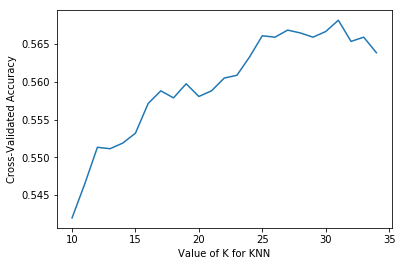

In [74]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn.fit(X, Y)
print(knn.score(X, Y))

# We will test the accuracy under different K
# 
k_range = range(10, 35)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
#Visualization
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

#### Decision Tree

In [75]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=None)
dt.fit(X, Y)
print(dt.score(X, Y))
dt_scores = cross_val_score(dt, X, Y, cv=5, scoring='accuracy')
print(dt_scores.mean())

0.992895868387
0.474309962268


#### Naive Bayes

In [76]:
nb = GaussianNB()
nb.fit(X, Y)
print(nb.score(X, Y))
nb_scores = cross_val_score(nb, X, Y, cv=5, scoring='accuracy')
print(nb_scores.mean())

0.53916619929
0.53992835321


#### Logistic Regression

In [77]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X, Y)
print(lr.score(X, Y))
lr_scores = cross_val_score(lr, X, Y, cv=5, scoring='accuracy')
print(lr_scores.mean())

0.593008038886
0.59263712266


### Conclusion on Method 1
1. It's sad to admit that method 1 is totally a fail. 
2. We've only got an accuracy around 50% and it's just a liite better than guessing(33%)

## Imply different algorithms on Method 2

#### Define X and Y

In [78]:
# Seperate our data into X and Y
X = method2.iloc[:, :-1]
X = X.as_matrix()
# X = preprocessing.scale(X)  # We normalize the data

Y = method2.iloc[:, -1]
Y = Y.replace({'win': 1, 'lose': 0, 'tie': -1})  # turn win, lose, and tie into 1, 0 and -1
Y = Y.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### KNN

0.992895868387


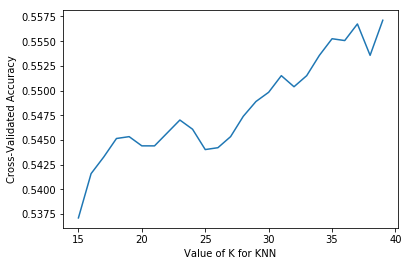

In [79]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn.fit(X, Y)
print(knn.score(X, Y))

# We will test the accuracy under different K
k_range = range(15, 40)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance',)
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
#Visualization
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

#### Decision Tree

In [80]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=50)
dt.fit(X, Y)
print(dt.score(X, Y))
dt_scores = cross_val_score(dt, X, Y, cv=5, scoring='accuracy')
print(dt_scores.mean())

0.992895868387
0.468878908789


#### Naive Bayes

In [81]:
nb = GaussianNB()
nb.fit(X, Y)
print(nb.score(X, Y))
nb_scores = cross_val_score(nb, X, Y, cv=5, scoring='accuracy')
print(nb_scores.mean())

0.555430921668
0.552259037587


#### Logistic Regression

In [82]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X, Y)
print(lr.score(X, Y))
lr_scores = cross_val_score(lr, X, Y, cv=5, scoring='accuracy')
print(lr_scores.mean())

0.592821088054
0.592634323402


### Conclusion on Method 2
1. It's sad to admit that method 2 also totally a fail. 
2. Because of this, I've decided to get back to data preprocessing and see if there's something that can help improve our prediction

## Imply different algorithms on Method 3

#### Define X and Y

In [83]:
# Seperate our data into X and Y
X = method3.iloc[:, :-2]  
X = X.as_matrix()
X = preprocessing.scale(X)  # We normalize the data

Y = method3.iloc[:, -1]
Y = Y.replace({'win': 1, 'lose': 0, 'tie': -1})  # turn win, lose, and tie into 1, 0 and -1
Y = Y.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### KNN

0.996628869139


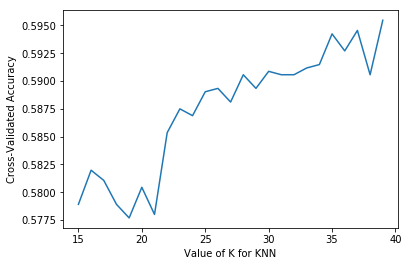

In [84]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn.fit(X, Y)
print(knn.score(X, Y))

# We will test the accuracy under different K
k_range = range(15, 40)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance',)
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
#Visualization
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

#### Decision Tree

In [85]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=50)
dt.fit(X, Y)
print(dt.score(X, Y))
dt_scores = cross_val_score(dt, X, Y, cv=5, scoring='accuracy')
print(dt_scores.mean())

0.996628869139
0.499234772969


#### Naive Bayes

In [86]:
nb = GaussianNB()
nb.fit(X, Y)
print(nb.score(X, Y))
nb_scores = cross_val_score(nb, X, Y, cv=5, scoring='accuracy')
print(nb_scores.mean())

0.584737971192
0.5786117606


#### Logistic Regression

In [87]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X, Y)
print(lr.score(X, Y))
lr_scores = cross_val_score(lr, X, Y, cv=5, scoring='accuracy')
print(lr_scores.mean())

0.6242721422
0.617232971417


### Conclusion on Method 3
1. At least we finally reach an accuracy over 60%
2. I guess it's also the best we can get if we're not puting more variables in it.
3. So I'll just stop here and get through our next part: World Cup Prediction

## World Cup Prediction

In [88]:
world_cup['new_date'] = '2018-06'

world_cup_ranking = pd.merge(world_cup, ranking, how='left', left_on=['new_date', 'Team1'], right_on=['new_date', 'country_full'])
world_cup_ranking = world_cup_ranking.loc[: , ['Group', 'new_date', 'Team1', 'rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
                                               'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 
                                               'three_year_ago_avg', 'three_year_ago_weighted', 'Team2']]

world_cup_ranking = pd.merge(world_cup_ranking, ranking, how='left', left_on=['new_date', 'Team2'], right_on=['new_date', 'country_full'])
world_cup_ranking = world_cup_ranking.drop(columns=['country_full', 'country_abrv', 'confederation', 'rank_date'])

#### Define Input X and use the model we've trainded from logistic regression to predict

In [91]:
X_test = world_cup_ranking.drop(columns=['Group', 'new_date', 'Team1', 'Team2'])
X_test = X_test.as_matrix()
X_test = preprocessing.scale(X_test)

world_cup['prediction'] = lr.predict(X_test)
world_cup['prediction'] = world_cup['prediction'].replace({1: 'win', 0: 'lose', -1: 'tie'})

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  0,  1, -1,  1,  0,  1,  1])

#### A little transformation to show which team wins in each match

In [112]:
def win_country(row):
    if row['prediction'] == 'lose':
        return row['Team2']
    if row['prediction'] == 'win':
        return row['Team1']
    if row['prediction'] == 'tie':
        return 'tie'
    
world_cup['outcome'] = world_cup.apply (lambda row: win_country (row),axis=1)
world_cup = world_cup.drop(columns=['prediction'])

In [123]:
world_cup

,Group,Team1,Team2,new_date,outcome
0,A,Russia,Saudi Arabia,2018-06,Saudi Arabia
1,A,Russia,Egypt,2018-06,Egypt
2,A,Russia,Uruguay,2018-06,Uruguay
3,A,Saudi Arabia,Egypt,2018-06,Egypt
4,A,Saudi Arabia,Uruguay,2018-06,Uruguay
5,A,Egypt,Uruguay,2018-06,Uruguay
6,B,Portugal,Spain,2018-06,Portugal
7,B,Portugal,Morocco,2018-06,Portugal
8,B,Portugal,IR Iran,2018-06,Portugal
9,B,Spain,Morocco,2018-06,Spain


### See how our first round prediction outcome looks like

In [122]:
world_cup.groupby(['Group'])['outcome'].value_counts()

Group  outcome     
A      Uruguay         3
       Egypt           2
       Saudi Arabia    1
B      Portugal        3
       Spain           2
       IR Iran         1
C      France          3
       Peru            2
       Denmark         1
D      Argentina       3
       Croatia         1
       Iceland         1
       tie             1
E      Brazil          3
       Costa Rica      1
       Switzerland     1
       tie             1
F      Germany         3
       Mexico          2
       Sweden          1
G      Belgium         3
       England         2
       Tunisia         1
H      Colombia        2
       Poland          2
       Senegal         1
       tie             1
Name: outcome, dtype: int64

#### By the outcome we've generated, I've made another excel file for round 16

### Round 16

In [141]:
round16 = pd.read_excel('/Users/alex/Desktop/SideProject/Soccer Prediction/World Cup 2018 Dataset.xlsx', sheet_name='16round')
round16['new_date'] = '2018-06'
round16

,Group,Team1,Team2,new_date
0,A,Uruguay,Spain,2018-06
1,B,France,Iceland,2018-06
2,C,Brazil,Mexico,2018-06
3,D,Belgium,Poland,2018-06
4,E,Portugal,Egypt,2018-06
5,F,Argentina,Peru,2018-06
6,G,Germany,Costa Rica,2018-06
7,H,Colombia,England,2018-06


In [142]:
round16_ranking = pd.merge(round16, ranking, how='left', left_on=['new_date', 'Team1'], right_on=['new_date', 'country_full'])
round16_ranking = round16_ranking.loc[: , ['Group', 'new_date', 'Team1', 'rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
                                               'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 
                                               'three_year_ago_avg', 'three_year_ago_weighted', 'Team2']]
round16_ranking = pd.merge(round16_ranking, ranking, how='left', left_on=['new_date', 'Team2'], right_on=['new_date', 'country_full'])
round16_ranking = round16_ranking.drop(columns=['country_full', 'country_abrv', 'confederation', 'rank_date'])

#### Define Input X and make a prediction by the model we've trained before

In [152]:
X_test = round16_ranking.drop(columns=['Group', 'new_date', 'Team1', 'Team2'])
X_test = X_test.as_matrix()
X_test = preprocessing.scale(X_test)

round16['prediction'] = lr.predict(X_test)
round16['prediction'] = round16['prediction'].replace({1: 'win', 0: 'lose', -1: 'tie'})

def win_country(row):
    if row['prediction'] == 'lose':
        return row['Team2']
    if row['prediction'] == 'win':
        return row['Team1']
    if row['prediction'] == 'tie':
        return 'tie'

round16['outcome'] = round16.apply (lambda row: win_country (row),axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### See the outcome of round 16

In [153]:
round16

,Group,Team1,Team2,new_date,prediction,outcome
0,A,Uruguay,Spain,2018-06,win,Uruguay
1,B,France,Iceland,2018-06,win,France
2,C,Brazil,Mexico,2018-06,win,Brazil
3,D,Belgium,Poland,2018-06,lose,Poland
4,E,Portugal,Egypt,2018-06,win,Portugal
5,F,Argentina,Peru,2018-06,win,Argentina
6,G,Germany,Costa Rica,2018-06,win,Germany
7,H,Colombia,England,2018-06,lose,England


### Quarter-Finals

In [154]:
round8 = pd.read_excel('/Users/alex/Desktop/SideProject/Soccer Prediction/World Cup 2018 Dataset.xlsx', sheet_name='8round')
round8['new_date'] = '2018-06'
round8

,Group,Team1,Team2,new_date
0,A,Uruguay,France,2018-06
1,B,Brazil,Poland,2018-06
2,C,Portugal,Argentina,2018-06
3,D,Germany,England,2018-06


In [155]:
round8_ranking = pd.merge(round8, ranking, how='left', left_on=['new_date', 'Team1'], right_on=['new_date', 'country_full'])
round8_ranking = round8_ranking.loc[: , ['Group', 'new_date', 'Team1', 'rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
                                               'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 
                                               'three_year_ago_avg', 'three_year_ago_weighted', 'Team2']]
round8_ranking = pd.merge(round8_ranking, ranking, how='left', left_on=['new_date', 'Team2'], right_on=['new_date', 'country_full'])
round8_ranking = round8_ranking.drop(columns=['country_full', 'country_abrv', 'confederation', 'rank_date'])

#### Define Input X and make a prediction by the model we've trained before

In [169]:
X_test = round8_ranking.drop(columns=['Group', 'new_date', 'Team1', 'Team2'])
X_test = X_test.as_matrix()
X_test = preprocessing.scale(X_test)

round8['prediction'] = lr.predict(X_test)
round8['prediction'] = round8['prediction'].replace({1: 'win', 0: 'lose', -1: 'tie'})

def win_country(row):
    if row['prediction'] == 'lose':
        return row['Team2']
    if row['prediction'] == 'win':
        return row['Team1']
    if row['prediction'] == 'tie':
        return 'tie'

round8['outcome'] = round8.apply (lambda row: win_country (row),axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [172]:
round8['prediction'] = lr.predict_proba(X_test)
round8 = round8.drop(columns=['prediction'])
round8  # We can see that there's a tie in our outcome, but it wouldn't happen in the quarter-finals, so we'll call out the probability.

,Group,Team1,Team2,new_date,outcome
0,A,Uruguay,France,2018-06,France
1,B,Brazil,Poland,2018-06,Poland
2,C,Portugal,Argentina,2018-06,tie
3,D,Germany,England,2018-06,Germany


In [173]:
lr.predict_proba(X_test) # After seeing this, we will turn the tie into 'Portugal'

array([[ 0.17276618,  0.64858067,  0.17865315],
       [ 0.22888548,  0.45985098,  0.31126354],
       [ 0.54317432,  0.04399836,  0.41282731],
       [ 0.09943836,  0.06763298,  0.83292866]])

### See the outcome of Quarter_Finals

In [182]:
round8['outcome'] = ['France', 'Poland', 'Portugal', 'Germany']
round8

,Group,Team1,Team2,new_date,outcome
0,A,Uruguay,France,2018-06,France
1,B,Brazil,Poland,2018-06,Poland
2,C,Portugal,Argentina,2018-06,Portugal
3,D,Germany,England,2018-06,Germany


### Semi-Finals

In [176]:
round4 = pd.read_excel('/Users/alex/Desktop/SideProject/Soccer Prediction/World Cup 2018 Dataset.xlsx', sheet_name='4round')
round4['new_date'] = '2018-06'
round4

,Group,Team1,Team2,new_date
0,A,France,Poland,2018-06
1,B,Portugal,Germany,2018-06


In [177]:
round4_ranking = pd.merge(round4, ranking, how='left', left_on=['new_date', 'Team1'], right_on=['new_date', 'country_full'])
round4_ranking = round4_ranking.loc[: , ['Group', 'new_date', 'Team1', 'rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
                                               'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 
                                               'three_year_ago_avg', 'three_year_ago_weighted', 'Team2']]
round4_ranking = pd.merge(round4_ranking, ranking, how='left', left_on=['new_date', 'Team2'], right_on=['new_date', 'country_full'])
round4_ranking = round4_ranking.drop(columns=['country_full', 'country_abrv', 'confederation', 'rank_date'])

In [178]:
X_test = round4_ranking.drop(columns=['Group', 'new_date', 'Team1', 'Team2'])
X_test = X_test.as_matrix()
X_test = preprocessing.scale(X_test)

round4['prediction'] = lr.predict(X_test)
round4['prediction'] = round4['prediction'].replace({1: 'win', 0: 'lose', -1: 'tie'})

def win_country(row):
    if row['prediction'] == 'lose':
        return row['Team2']
    if row['prediction'] == 'win':
        return row['Team1']
    if row['prediction'] == 'tie':
        return 'tie'

round4['outcome'] = round4.apply (lambda row: win_country (row),axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [179]:
round4['prediction'] = lr.predict_proba(X_test)
round4 = round4.drop(columns=['prediction'])
round4  # We can see that there's a tie in our outcome, but it wouldn't happen in the quarter-finals, so we'll call out the probability.

,Group,Team1,Team2,new_date,outcome
0,A,France,Poland,2018-06,France
1,B,Portugal,Germany,2018-06,tie


In [180]:
lr.predict_proba(X_test) # After seeing this, we will turn the tie into 'Germany'

array([[ 0.14190675,  0.16086621,  0.69722705],
       [ 0.4592164 ,  0.26113111,  0.27965249]])

### See the outcome of Semi-Finals

In [181]:
round4['outcome'] = ['France', 'Germany']
round4

,Group,Team1,Team2,new_date,outcome
0,A,France,Poland,2018-06,France
1,B,Portugal,Germany,2018-06,Germany


## Finals

In [183]:
finals = pd.read_excel('/Users/alex/Desktop/SideProject/Soccer Prediction/World Cup 2018 Dataset.xlsx', sheet_name='finals')
finals['new_date'] = '2018-06'
finals

,Group,Team1,Team2,new_date
0,A,France,Germany,2018-06


In [184]:
finals_ranking = pd.merge(finals, ranking, how='left', left_on=['new_date', 'Team1'], right_on=['new_date', 'country_full'])
finals_ranking = finals_ranking.loc[: , ['Group', 'new_date', 'Team1', 'rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
                                               'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 
                                               'three_year_ago_avg', 'three_year_ago_weighted', 'Team2']]
finals_ranking = pd.merge(finals_ranking, ranking, how='left', left_on=['new_date', 'Team2'], right_on=['new_date', 'country_full'])
finals_ranking = finals_ranking.drop(columns=['country_full', 'country_abrv', 'confederation', 'rank_date'])

In [185]:
X_test = finals_ranking.drop(columns=['Group', 'new_date', 'Team1', 'Team2'])
X_test = X_test.as_matrix()
X_test = preprocessing.scale(X_test)

finals['prediction'] = lr.predict(X_test)
finals['prediction'] = finals['prediction'].replace({1: 'win', 0: 'lose', -1: 'tie'})

def win_country(row):
    if row['prediction'] == 'lose':
        return row['Team2']
    if row['prediction'] == 'win':
        return row['Team1']
    if row['prediction'] == 'tie':
        return 'tie'

finals['outcome'] = finals.apply (lambda row: win_country (row),axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### See the outcome of Finals

In [186]:
finals['prediction'] = lr.predict_proba(X_test)
finals = finals.drop(columns=['prediction'])
finals 

,Group,Team1,Team2,new_date,outcome
0,A,France,Germany,2018-06,France


## Conclusion
1. In my prediction, the outcome is that France wins the world cup in 2018. Since the world cup is still running, I guess we will come back later to see how well we did.
2. I list out some problems I've met when doing this project: 
    * The first problems is that I should gather more data, such as different countries' GDP and how many US dollars they've spent on soccer to improve the accuracy.
    * The second part is that I should take the scores of each team as Y because I've met a lot of problems only using 'win', 'lose', and 'tie'.
    * The last is that I should learn more algorithms. Here I didn't use RandomForest, SVM, adaboost... etc. It's because I only use the algorithms that I really know the background mathematics. But unfortunately, these algorithms didn't perform well this time.
    * I should make a visualization, but it will take a lot more time and I guess I'll come back and do this part later.
3. Feel Free to leave any comments or tell me where I can improve this project.